# Full VE problem analysis template

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import sympy as sym
import torch
from scipy.io import loadmat

sys.path.append('../src')
import deepymod_torch.VE_datagen as VE_datagen
from deepymod_torch.library_function import stress_input_library
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.VE_params import coeffs_from_model_params

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Data generation

> The below cell is very important for preparing the generation, examination, and saving of the data. It is one of only a few cells that requires configuration in the notebook.

In [6]:
omega = 1
E = [5, 1]
eta = [1]
#t = sym.symbols('t', real=True)
#input_expr = sym.sinc(omega*t)
input_expr = lambda t: np.sin(omega*t)/(omega*t)
dsigma = lambda t: (1/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
input_torch_lambda = lambda t: torch.sin(omega*t)/(omega*t)
input_type = 'Stress'
func_desc = 'Sinc'
time_array = np.linspace(0.00001, 20, 5000)

In [7]:
data = loadmat('Order_2_Tau_5_strain.mat')

In [8]:
usol = np.real(data['Expression1'])
usol= usol.reshape((5981,3))

In [14]:
time_array = np.expand_dims(usol[:,0],axis=1)
strain_array = -(np.expand_dims(usol[:,1],axis=1)) + 1
stress_array = np.expand_dims(usol[:,2],axis=1) + 1
stress_array_recalc = np.array([input_expr(t) for t in time_array])

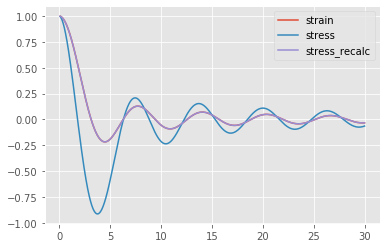

In [15]:
plt.plot(time_array, strain_array.flatten(), label='strain')
plt.plot(time_array, stress_array.flatten(), label='stress')
plt.plot(time_array, stress_array_recalc.flatten(), label='stress_recalc')
plt.legend()

## Data Treatment

In [7]:
time_array = time_array.reshape(-1, 1)
strain_array = strain_array.reshape(-1, 1)

In [8]:
noise_level = 0
noisy_strain_array = strain_array + noise_level * np.std(strain_array) * np.random.standard_normal(strain_array.shape)

In [9]:
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_array.size)
reduced_time_array = time_array[reordered_row_indices, :][:number_of_samples].astype(np.float32)
reduced_strain_array = noisy_strain_array[reordered_row_indices, :][:number_of_samples].astype(np.float32)

## DeepMod prep

In [10]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
strain_tensor = torch.tensor(reduced_strain_array, dtype=torch.float32)

In [11]:
optim_config = {'lambda': 10**-5, 'max_iterations': 30001}

In [12]:
network_config = {'input_dim': 1, 'hidden_dim': 30, 'layers': 4, 'output_dim': 1}

In [13]:
lib_config = {'type': stress_input_library, 'diff_order': 2, 'coeff_sign': 'positive', 'input_type': input_type, 'input_expr': input_torch_lambda}

## Running DeepMoD

In [14]:
not_floats = coeffs_from_model_params(E, eta)
[float(x) for x in not_floats]

[1.0, 1.2, 0.2]

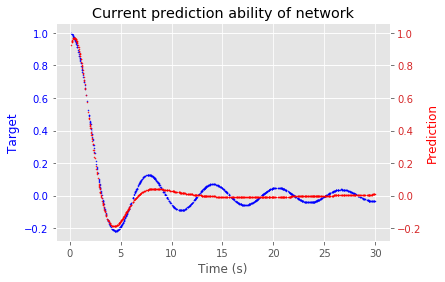

Epoch | Total loss | MSE | PI | L1 
4600 2.2E-03 2.0E-03 1.2E-04 4.0E-05
tensor([[1.0288],
        [1.3370],
        [0.0914],
        [0.0122],
        [0.1680]], requires_grad=True)
lrs are 0.001 0.001
Time elapsed: 5.0 minutes 25.773651123046875 seconds


KeyboardInterrupt: 

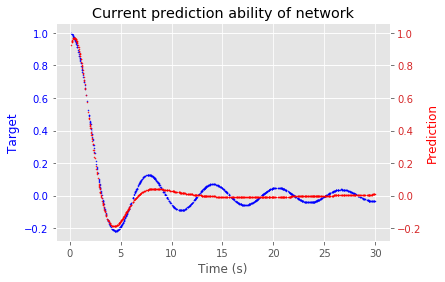

In [16]:
sparse_coeff_vector, sparsity_mask, network = DeepMoD(time_tensor, strain_tensor, network_config, lib_config, optim_config)

### Results

In [ ]:
sparse_coeff_vector

In [ ]:
sparsity_mask

## Results Processing

> Run as far as here in one shot, then check that the below two code cells are correct, in particular, the string, `success_state` cannot be preset.

In [ ]:
success_state = 'Fail'

In [ ]:
investigated_param = 'Decay Constant'
param_value = 8*np.pi
repeat_instance = 2

> From here, you can run the rest of the code.

In [ ]:
stress_array = stress_array.reshape(-1,1)
reduced_stress_array = stress_array[reordered_row_indices, :][:number_of_samples]

prediction_array = np.array(network(time_tensor).detach())

if `prediction_coeffs_array` is not equal dimensionally to the `target_coeffs_array`, there would be an error if it weren't for the `if` statement prempting this. In the case where the dimensions don't agree, there is no sensible way to assess these quantities anyway, so this data is simply abandoned.

In [ ]:
target_coeffs_array = np.array(not_floats).reshape(-1,1)
prediction_coeffs_array = np.array(sparse_coeff_vector[0].detach())
good_dims = False
if target_coeffs_array.shape == prediction_coeffs_array.shape:
    coeffs_ME = np.sum(abs(target_coeffs_array - prediction_coeffs_array))/len(not_floats)
    coeffs_ME = np.array(coeffs_ME).reshape(1)
    sparsity_mask_array = np.array(sparsity_mask[0]).reshape(-1,1)
    good_dims = True

if statement just bypasses errors

In [ ]:
series_data = np.concatenate((reduced_time_array, reduced_strain_array, reduced_stress_array, prediction_array), axis=1)
if good_dims:
    coeffs_data = np.concatenate((target_coeffs_array, prediction_coeffs_array, sparsity_mask_array), axis=1)

In [ ]:
DG_info_list = [str(omega), str(E), str(eta), input_type, func_desc]
DG_info_list

In [ ]:
misc_list = [investigated_param, str(param_value), str(repeat_instance), success_state]
misc_list

## Saving

In [ ]:
first_subfolder = investigated_param
second_subfolder = 'param_' + str(param_value).replace('.', '-')
third_subfolder = 'repeat_' + str(repeat_instance)

parent_folder = '../data/Results'

foldername = parent_folder + '/' + first_subfolder + '/' + second_subfolder + '/' + third_subfolder

In [ ]:
if not os.path.isdir(foldername):
    os.makedirs(foldername)

In [ ]:
np.savetxt(foldername+'/series_data.csv', series_data, delimiter=',', header='Time, Target_Strain, Stress, Prediction_Strain')

if statement just bypasses errors

In [ ]:
if good_dims:
    np.savetxt(foldername+'/coeffs_data.csv', coeffs_data, delimiter=',', header='Target_Coeffs, Prediction_Coeffs, Sparsity_Mask')
    np.savetxt(foldername+'/error.csv', coeffs_ME, delimiter=',')

In [ ]:
with open(foldername+'/misc_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in misc_list)

In [ ]:
with open(foldername+'/DG_info_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in DG_info_list)

Epoch | Total loss | MSE | PI | L1 
5000 1.4E-06 2.4E-07 1.2E-06 0.0E+00
tensor([[-0.9992]], requires_grad=True)
lrs are 0.001 0.001
Total time elapsed: 5.0 minutes 14.440114498138428 seconds


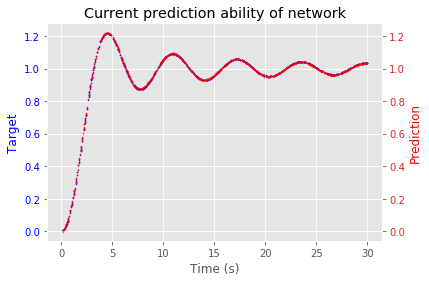

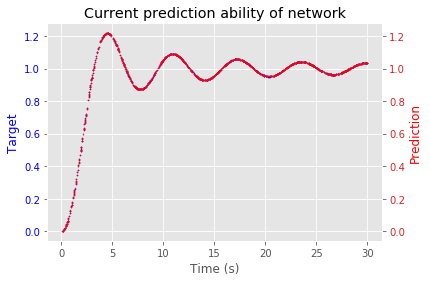

In [20]:
sparse_coeff_vector, sparsity_mask, network = DeepMoD(time_tensor, strain_tensor, network_config, lib_config, optim_config)